In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

In [36]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
# weekly_df = weekly_df.iloc[209:]
weekly_df.index = pd.DatetimeIndex(weekly_df.index)

train_mask = (weekly_df.index > "2006") & (weekly_df.index <= "2011")
train = weekly_df[train_mask].cases
test_mask = (weekly_df.index > "2011")
test = weekly_df[test_mask].cases

In [37]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$Seasonal\,Part_{0} = \,s_{0}* \,\sin(\dfrac{\pi\,x}{52}) \, + \,s_{0}$$

$$Seasonal\,Part_{1} =\,A\cos^2(k\,x +\, \phi)$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+ Seasonal\,Part$$

For forecasts of future values in period T + r on the original scale. if a transformation was used, say, x1 = In y, then the forecast made at the end of period T for T + r would be obtained by reversing the transformation. For the natural log this would be to exponetiate it back

## maximize for all betas values is needed
- the cases part needs lag + 1
- the population which is float needs 1
- the seasonality part needs 3

if we have 26 lags to predict for the next week, we would have to maximize for a set of 31 betas

In [133]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

LAG = 26
W_CASE = LAG + 1
W_POP = 1
W_SEASON = 2
BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

# starting point of phi should be 30,
# and
def season(w,x):
#     thr_yr = 3*52
#     pi = np.math.pi
#     sine = np.math.sin((pi*x)/float(52))
#     return w[-2]*(sine) + w[-2]
    inside = (w[-3]*x - w[-2])
    cosine_sq = np.math.cos(inside)**2
#     return w[-4]*cosine_sq
    return cosine_sq

def theta(w,y):
    pad_y = np.concatenate(([1],np.array(y)))
    score = np.dot(w[:-4],pad_y)
    return expit(score)

def guess(w,x_week,y_case):
    return np.log(theta(w,y_case)+ 1e-5) + season(w,x_week) + w[-1] # w[-3] + season

def cost(w):
    ret = 0
    for week_no in range(len(train)-BETAS_SET):
        real_case = np.log(train[week_no+W_CASE])
        predicted_case = guess(w,week_no,train[week_no:week_no+LAG])
        ret += (real_case - predicted_case)**2
    print ret/float(len(train))
    return ret/float(len(train))

pi = np.math.pi
seasonality_starters = [1500.,(pi),(pi / 52.)] #[1500.,(pi/50),(20*pi / 52.)] # [pop,period,peak]
arr = np.array([0.]*W_CASE) # 27 betas
arr = np.append(arr,seasonality_starters) # 30 betas
arr = np.append(arr,pop_starter) # 31 betas
w = minimize(cost,arr)


1.73879374218
1.73879375844
1.73881613592
1.73881622184
1.7388163028
1.73881632539
1.7388163233
1.73881630673
1.73881631335
1.73881627178
1.73881619384
1.73881609923
1.738815978
1.73881580418
1.73881560082
1.73881529532
1.73881491611
1.73881460161
1.73881413412
1.73881362753
1.73881309532
1.7388125734
1.73881200807
1.73881145755
1.73881090945
1.73881038799
1.73880993493
1.73880958959
1.73879374218
1.738794138
1.73879373826
1.7387937747
1.73879374218
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1901093865
86.1900823518
86.1901095796
86.190109127
82.4294892003
82.4294892003
82.4294892003
82.4294892003
82.4294892003
82.4294892003
8

In [137]:
w.x

array([ -2.08454140e+00,  -1.32660715e-04,   4.93710843e-05,
         1.09192439e-04,  -4.51099935e-05,  -1.57573610e-04,
        -1.57049576e-05,  -6.33068048e-05,   1.23327590e-05,
         1.11960353e-04,   1.67441598e-04,  -2.98496564e-05,
        -9.84351405e-05,  -3.03573204e-04,   2.26165041e-04,
         2.63604928e-04,  -3.34840517e-04,  -1.09033997e-04,
         1.09645735e-04,   2.62274849e-04,   1.31579201e-05,
        -8.69734680e-05,  -2.82548385e-04,  -3.29607442e-04,
         6.39511373e-05,   2.38804416e-04,   1.33157146e-03,
         1.50000000e+03,   3.14448393e+00,   5.59809406e-01,
         7.37526345e+00])

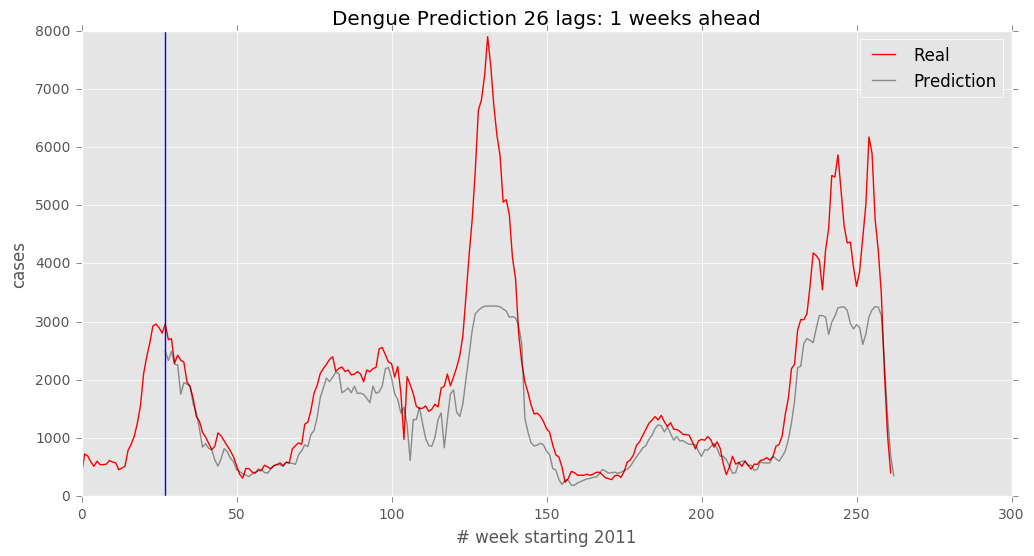

In [135]:
NWEEKS = 26

nweek_to_predict = [1,2,4]

def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for week_no in range(weeks_ahead):
        theta = np.exp(guess(w.x,week_no,arr))
        arr = np.append(arr[1:],theta)
    return theta

for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(test)-N):
        initial_arr = test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i))
    
    title = 'Dengue Prediction 26 lags: %d weeks ahead'%i
    make_line(NWEEKS+i,test,tmp,title,"# week starting 2011","cases")
    break
        

In [136]:
tmp

[2489.1767530004149,
 2330.596149165061,
 2487.4014073191775,
 2266.4342379741202,
 2252.8271747033273,
 1749.646164726468,
 1948.842109235756,
 1923.8155202145442,
 1886.5478321973903,
 1585.6163669437203,
 1443.9154633448807,
 1160.8312190732115,
 838.56403239506778,
 899.54449013343594,
 818.80143231727777,
 793.37596575748046,
 618.90053852212679,
 512.43464324357774,
 637.76516050432315,
 813.64386787801595,
 761.75074347481723,
 651.31914433300915,
 591.31109021417285,
 450.95619674920169,
 419.34853500889125,
 378.82719191078456,
 357.49859327595578,
 333.65515147953931,
 379.77340203796615,
 389.47017478241605,
 462.83381223955433,
 451.26026878273535,
 403.86491961689291,
 390.58242549617421,
 462.93871423702188,
 515.53435393711368,
 535.9599318622262,
 536.70272594529308,
 509.58850101735436,
 574.42674033546518,
 562.92843080019236,
 563.44508813738889,
 543.86354896565581,
 704.79147276950414,
 777.84871410624271,
 878.67138236533094,
 848.46165146446879,
 1056.90037331411

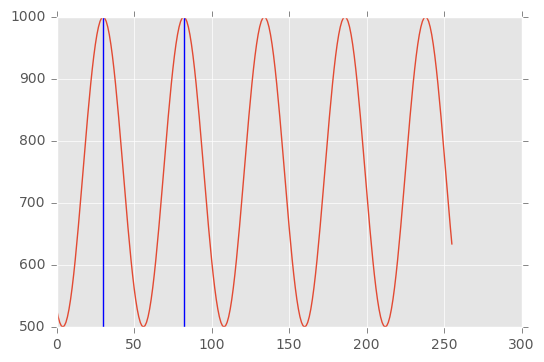

In [139]:
def trial(wk_no):
    period = np.math.pi / 52
    inside = (period*wk_no) - (30*np.math.pi / 52.)
    cosine_sq = np.math.cos(inside)**2
    return cosine_sq

idx = [i for i in range(128*2)]
idy = [trial(i) for i in idx]

plt.plot(idx,idy)
plt.axvline(30)
plt.axvline(82)

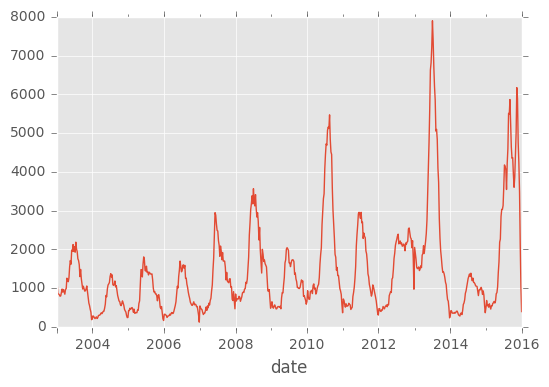

In [71]:
weekly_df.cases.plot()

In [ ]:
BETAS_SET = lag + 1
ALL_WS = BETAS_SET + 1

def guess(w,x):
    def theta(w,x):
        pad_x = np.concatenate(([1],np.array(x)))
        score = np.dot(w[:-1],pad_x)
        return expit(score)

    return np.log(theta(w,x)+ 1e-5) + w[-1] 

def cost(w):
    ret = 0
    for i in range(len(train)-ALL_WS):
        real_case = np.log(train[i+ALL_WS])
        predicted_case = guess(w,train[i:i+lag])
        ret += (real_case - predicted_case)**2
    return ret/float(len(train))

starter = np.log(3000.)#np.log(7500.)
arr = np.array([0.]*BETAS_SET)
arr = np.append(arr,starter)
w = minimize(cost,arr).x